Ô 1: Imports và cài đặt (nếu cần)

In [1]:
# Ô 1: Imports và cài đặt
# Cài đặt nếu chạy trên Colab và chưa có (chạy ô này một lần nếu cần)
# !pip install qiskit qiskit-aer matplotlib pandas

import os
import sys
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator # Backend để transpile
import matplotlib.pyplot as plt
import pandas as pd # Để hiển thị kết quả dạng bảng

# --- Xử lý import module cục bộ (quan trọng cho Jupyter Notebook) ---
# Đoạn code này giúp notebook tìm thấy các file .py của bạn.
# Đảm bảo notebook này nằm trong thư mục "Thắng-Grover" cùng với các file .py.
print(f"Thư mục làm việc ban đầu (CWD) của kernel: {os.getcwd()}")

# Cố gắng xác định thư mục gốc của dự án (Thắng-Grover)
# và thêm nó vào sys.path nếu cần
project_directory = os.getcwd() 
# Điều chỉnh nếu notebook của bạn nằm trong thư mục con của "Thắng-Grover"
# Ví dụ, nếu CWD là "e:\some_other_folder" và dự án của bạn ở "e:\Thắng-Grover"
# thì bạn cần đặt project_directory = r"e:\Thắng-Grover" (thay r"..." bằng đường dẫn đúng)

# Kiểm tra xem có đúng là thư mục dự án không bằng cách tìm một file đặc trưng
if not (os.path.exists(os.path.join(project_directory, 'diffuser.py')) and \
        os.path.exists(os.path.join(project_directory, 'grover_builder.py'))):
    
    # Thử tìm ở thư mục cha nếu CWD hiện tại không chứa các file .py
    parent_dir = os.path.abspath(os.path.join(project_directory, os.pardir))
    if os.path.exists(os.path.join(parent_dir, 'diffuser.py')) and \
       os.path.exists(os.path.join(parent_dir, 'grover_builder.py')):
        project_directory = parent_dir
        if os.getcwd() != project_directory: # Chỉ đổi CWD nếu nó khác
             try:
                 os.chdir(project_directory)
                 print(f"Đã đổi CWD sang thư mục dự án: {project_directory}")
             except Exception as e_chdir:
                 print(f"Không thể đổi CWD sang {project_directory}: {e_chdir}")

    else:
        print(f"CẢNH BÁO: Không thể tự động xác định chính xác thư mục dự án 'Thắng-Grover' "
              f"chứa các file .py từ CWD hiện tại: {os.getcwd()}")
        print("Hãy đảm bảo notebook này được chạy từ bên trong thư mục 'Thắng-Grover', "
              "hoặc bạn đã mở VS Code bằng cách mở thư mục 'Thắng-Grover' làm thư mục gốc.")

# Thêm thư mục dự án (nơi chứa các file .py) vào đầu sys.path
if project_directory not in sys.path:
    sys.path.insert(0, project_directory)
    print(f"Đã thêm '{project_directory}' vào sys.path.")
# Thêm cả thư mục hiện tại của kernel nếu nó khác và chưa có (dự phòng)
current_kernel_cwd = os.getcwd()
if current_kernel_cwd != project_directory and current_kernel_cwd not in sys.path:
    sys.path.insert(0, current_kernel_cwd)
    print(f"Đã thêm CWD của kernel '{current_kernel_cwd}' vào sys.path.")

print(f"\nThư mục làm việc giả định của dự án (nơi tìm module): {project_directory}")
print(f"Kiểm tra file trong thư mục dự án giả định: {os.listdir(project_directory if os.path.isdir(project_directory) else '.')}")


# Import các hàm bạn đã viết từ .py files
try:
    from diffuser import build_diffuser 
    from grover_builder import build_grover_circuit, create_complex_mock_oracle # <<< IMPORT HÀM NÀY
    print("\nCác hàm build_diffuser, build_grover_circuit, và create_complex_mock_oracle đã được import thành công.")
except ModuleNotFoundError as e:
    print(f"\nLỖI IMPORT: {e}")
    print("Hãy đảm bảo các file diffuser.py và grover_builder.py nằm trong thư mục làm việc "
          "mà Python có thể tìm thấy (đã được thêm vào sys.path), "
          "và bạn đã khởi động lại kernel nếu vừa tạo hoặc di chuyển file.")
except Exception as e_general:
    print(f"\nLỗi không xác định khi import: {e_general}")

Thư mục làm việc ban đầu (CWD) của kernel: e:\thang_grover
Đã thêm 'e:\thang_grover' vào sys.path.

Thư mục làm việc giả định của dự án (nơi tìm module): e:\thang_grover
Kiểm tra file trong thư mục dự án giả định: ['diffuser.py', 'diffuser_benchmarks.csv', 'grover_benchmark.ipynb', 'grover_builder.py', 'grover_builder_test_scenario1.png', 'grover_builder_test_scenario2.png', 'grover_circuit_benchmarks.csv', 'grover_circuit_benchmarks_optimized.csv', 'output.png', '__pycache__']

Các hàm build_diffuser, build_grover_circuit, và create_complex_mock_oracle đã được import thành công.


Ô 3: Thiết lập Backend và Tham số Benchmark

In [2]:
# Khởi tạo AerSimulator làm backend mục tiêu cho transpile
aer_sim = AerSimulator()

# Danh sách các giá trị n_qubits (số qubit tìm kiếm) để benchmark
n_search_qubits_values = [4, 6, 8, 10] 
# (Bạn có thể thay đổi danh sách này)

# Danh sách để lưu kết quả benchmark
grover_benchmark_data = []

print("Đã khởi tạo Simulator và các tham số benchmark.")

Đã khởi tạo Simulator và các tham số benchmark.


Ô 4: Chạy Benchmark Mạch Grover

In [3]:
# Ô 4: Chạy Vòng Lặp Benchmark Mạch Grover (So sánh các mức tối ưu hóa)

print("\n--- BẮT ĐẦU BENCHMARK MẠCH GROVER (SO SÁNH TỐI ƯU HÓA) ---")

# Thiết lập cố định cho Kịch bản 2 (ví dụ)
n_search_qubits_scenario = 4
num_ancillas_for_oracle_scenario = 2
target_key_for_oracle_scenario = "1010" 
iterations_scenario = 3 

# Làm mới danh sách kết quả
grover_benchmark_data = []

print(f"\nBenchmarking cho {n_search_qubits_scenario} qubit tìm kiếm, Oracle {n_search_qubits_scenario + num_ancillas_for_oracle_scenario} qubit, {iterations_scenario} vòng lặp...")

# 1. Tạo Mock Oracle
print(f"  Tạo Mock Oracle để đánh dấu trạng thái: '{target_key_for_oracle_scenario}'...")
oracle_for_benchmark = create_complex_mock_oracle( # Hoặc create_complex_mock_oracle nếu bạn dùng hàm đó
    n_search_qubits=n_search_qubits_scenario, 
    num_oracle_ancillas=num_ancillas_for_oracle_scenario,
    mark_state_str=target_key_for_oracle_scenario
)
print(f"  Mock Oracle được tạo với {oracle_for_benchmark.num_qubits} qubits tổng cộng.")
print(f"  Số lần lặp Grover: {iterations_scenario}")

# 2. Xây dựng mạch Grover hoàn chỉnh
print(f"  Xây dựng mạch Grover...")
grover_circuit_to_benchmark = build_grover_circuit(
    n_qubits=n_search_qubits_scenario, 
    iterations=iterations_scenario, 
    oracle_circuit=oracle_for_benchmark
)
initial_depth = grover_circuit_to_benchmark.depth()
initial_ops = dict(grover_circuit_to_benchmark.count_ops())
print(f"  Mạch Grover được xây dựng với {grover_circuit_to_benchmark.num_qubits} qubits tổng cộng.")
print(f"    Độ sâu ban đầu (mạch logic): {initial_depth}")
print(f"    Số cổng ban đầu: {initial_ops}")

# 3. Transpile với optimization_level=0 (Chủ yếu phân rã)
print("  Transpiling mạch Grover (optimization_level=0 - Chỉ phân rã)...")
try:
    transpiled_qc_level_0 = transpile(grover_circuit_to_benchmark, backend=aer_sim, optimization_level=0)
    depth_level_0 = transpiled_qc_level_0.depth()
    ops_level_0 = dict(transpiled_qc_level_0.count_ops())
    num_qubits_level_0 = transpiled_qc_level_0.num_qubits
    print(f"    Độ sâu (level 0): {depth_level_0}")
    print(f"    Số qubit (level 0): {num_qubits_level_0}")
    print(f"    Số cổng (level 0): {ops_level_0}")
except Exception as e:
    print(f"    LỖI khi transpile (level 0): {e}")
    depth_level_0 = 'Error_L0'
    ops_level_0 = {'Error_L0': 1}
    num_qubits_level_0 = grover_circuit_to_benchmark.num_qubits


# 4. Transpile với optimization_level=3 (Tối ưu hóa mạnh)
print("  Transpiling mạch Grover (optimization_level=3 - Tối ưu mạnh)...")
try:
    transpiled_qc_level_3 = transpile(grover_circuit_to_benchmark, backend=aer_sim, optimization_level=3)
    depth_level_3 = transpiled_qc_level_3.depth()
    ops_level_3 = dict(transpiled_qc_level_3.count_ops())
    num_qubits_level_3 = transpiled_qc_level_3.num_qubits
    print(f"    Độ sâu (level 3): {depth_level_3}")
    print(f"    Số qubit (level 3): {num_qubits_level_3}")
    print(f"    Số cổng (level 3): {ops_level_3}")
except Exception as e:
    print(f"    LỖI khi transpile (level 3): {e}")
    depth_level_3 = 'Error_L3'
    ops_level_3 = {'Error_L3': 1}
    num_qubits_level_3 = grover_circuit_to_benchmark.num_qubits
    
# Lưu kết quả
grover_benchmark_data.append({
    'scenario': f'Kịch bản ({n_search_qubits_scenario}s+{num_ancillas_for_oracle_scenario}a)',
    'n_search_qubits': n_search_qubits_scenario,
    'oracle_total_qubits': oracle_for_benchmark.num_qubits,
    'grover_iterations': iterations_scenario,
    'initial_depth': initial_depth,
    'initial_ops_sum': sum(initial_ops.values()), # Tổng số cổng ban đầu
    'depth_level_0': depth_level_0,
    'ops_sum_level_0': sum(ops_level_0.values()) if isinstance(depth_level_0, int) else 'N/A',
    'depth_level_3': depth_level_3,
    'ops_sum_level_3': sum(ops_level_3.values()) if isinstance(depth_level_3, int) else 'N/A',
    'num_qubits_final': num_qubits_level_3 if isinstance(depth_level_3, int) else num_qubits_level_0
})

print("\n--- HOÀN THÀNH BENCHMARK SO SÁNH TỐI ƯU HÓA ---")


--- BẮT ĐẦU BENCHMARK MẠCH GROVER (SO SÁNH TỐI ƯU HÓA) ---

Benchmarking cho 4 qubit tìm kiếm, Oracle 6 qubit, 3 vòng lặp...
  Tạo Mock Oracle để đánh dấu trạng thái: '1010'...
  Mock Oracle được tạo với 6 qubits tổng cộng.
  Số lần lặp Grover: 3
  Xây dựng mạch Grover...
  Mạch Grover được xây dựng với 6 qubits tổng cộng.
    Độ sâu ban đầu (mạch logic): 40
    Số cổng ban đầu: {'x': 48, 'h': 34, 'barrier': 13, 'mcx_recursive': 6, 'z': 3, 'mcx': 3}
  Transpiling mạch Grover (optimization_level=0 - Chỉ phân rã)...
    Độ sâu (level 0): 349
    Số qubit (level 0): 6
    Số cổng (level 0): {'h': 142, 'cx': 108, 'u1': 96, 'cu1': 54, 'x': 48, 'u2': 48, 'barrier': 13, 'z': 3, 'mcx': 3}
  Transpiling mạch Grover (optimization_level=3 - Tối ưu mạnh)...
    Độ sâu (level 3): 253
    Số qubit (level 3): 6
    Số cổng (level 3): {'cx': 108, 'u2': 72, 'cu1': 54, 'u1': 36, 'h': 16, 'barrier': 13, 'x': 12, 'u3': 3, 'mcx': 3}

--- HOÀN THÀNH BENCHMARK SO SÁNH TỐI ƯU HÓA ---


Ô 5: Hiển thị Kết quả Benchmark (Dạng bảng)

In [4]:
# Ô 5: Hiển thị Kết quả Benchmark (Dạng bảng) - Sửa đổi
if grover_benchmark_data:
    df_grover_results = pd.DataFrame(grover_benchmark_data)
    print("\n--- KẾT QUẢ BENCHMARK MẠCH GROVER (SO SÁNH TỐI ƯU HÓA) ---")
    
    columns_to_display = [
        'n_search_qubits', 
        'grover_iterations',
        'oracle_total_qubits',
        'initial_depth', 
        'initial_ops_sum',
        'depth_level_0',      # Độ sâu sau khi chỉ phân rã
        'ops_sum_level_0',    # Tổng cổng sau khi chỉ phân rã
        'depth_level_3',      # Độ sâu sau khi tối ưu mạnh
        'ops_sum_level_3',    # Tổng cổng sau khi tối ưu mạnh
        'num_qubits_final'
    ]
    # Đảm bảo chỉ chọn các cột thực sự có trong DataFrame
    existing_columns_to_display = [col for col in columns_to_display if col in df_grover_results.columns]

    print(df_grover_results[existing_columns_to_display])
    
    csv_filename_grover = "grover_circuit_benchmarks_optimized.csv" # Đổi tên file nếu muốn
    try:
        df_grover_results.to_csv(csv_filename_grover, index=False)
        print(f"\nĐã lưu kết quả benchmark mạch Grover vào file: {csv_filename_grover}")
    except Exception as e:
        print(f"Lỗi khi lưu file CSV: {e}")
else:
    print("\nKhông có dữ liệu benchmark mạch Grover để hiển thị hoặc lưu.")


--- KẾT QUẢ BENCHMARK MẠCH GROVER (SO SÁNH TỐI ƯU HÓA) ---
   n_search_qubits  grover_iterations  oracle_total_qubits  initial_depth  \
0                4                  3                    6             40   

   initial_ops_sum  depth_level_0  ops_sum_level_0  depth_level_3  \
0              107            349              515            253   

   ops_sum_level_3  num_qubits_final  
0              317                 6  

Đã lưu kết quả benchmark mạch Grover vào file: grover_circuit_benchmarks_optimized.csv


In [5]:
print(grover_benchmark_data)

[{'scenario': 'Kịch bản (4s+2a)', 'n_search_qubits': 4, 'oracle_total_qubits': 6, 'grover_iterations': 3, 'initial_depth': 40, 'initial_ops_sum': 107, 'depth_level_0': 349, 'ops_sum_level_0': 515, 'depth_level_3': 253, 'ops_sum_level_3': 317, 'num_qubits_final': 6}]


Ô 6: Vẽ Biểu đồ

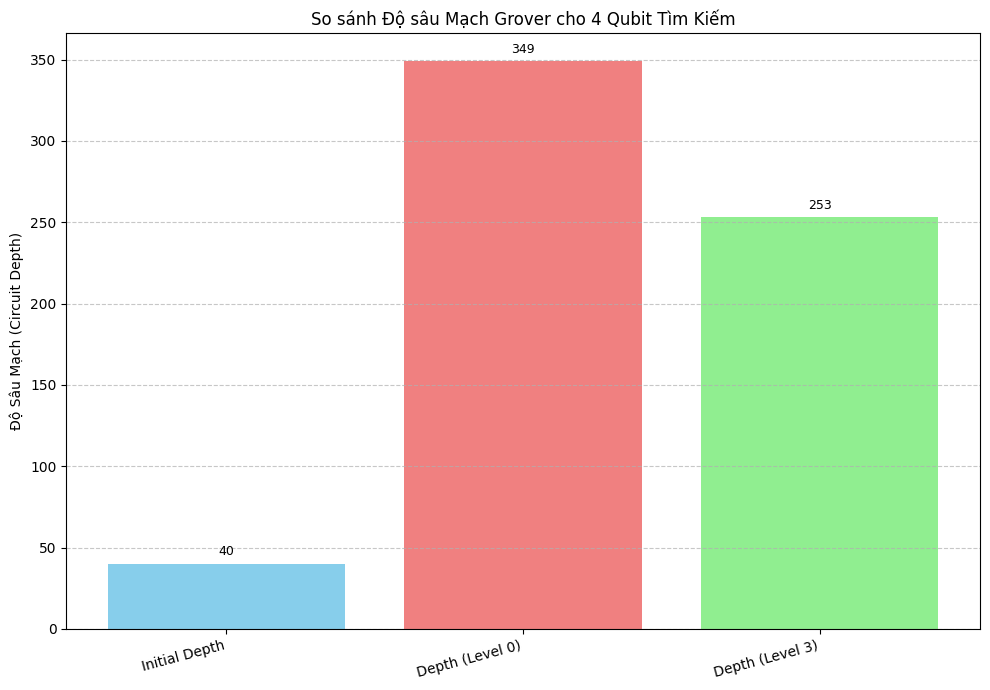


--- Thông tin chi tiết về số cổng ---
  Số qubit tìm kiếm: 4
  Tổng số cổng ban đầu (Initial Ops Sum): 107
  Tổng số cổng (Level 0 Ops Sum): 515
  Tổng số cổng (Level 3 Ops Sum): 317
  Tổng số qubit sau transpile (Final Qubits): 6


In [6]:
# Ô 6: Vẽ Biểu đồ và Hiển thị Thông tin Chi tiết (Đã sửa lỗi kiểm tra kiểu)

import pandas as pd # Đảm bảo pandas đã được import
import matplotlib.pyplot as plt # Đảm bảo matplotlib.pyplot đã được import
import numbers # Import module numbers để kiểm tra kiểu số một cách tổng quát

if grover_benchmark_data:
    df_plot_grover = pd.DataFrame(grover_benchmark_data)

    if not df_plot_grover.empty:
        # Lấy dòng dữ liệu đầu tiên (hoặc duy nhất nếu chỉ có một kịch bản benchmark)
        data_point = df_plot_grover.iloc[0]

        # --- Các dòng gỡ lỗi (bạn có thể bỏ chú thích để kiểm tra) ---
        # print(f"DEBUG: Toàn bộ data_point:\n{data_point.to_dict()}")
        # print(f"DEBUG: Giá trị initial_depth: {data_point.get('initial_depth')}, Kiểu: {type(data_point.get('initial_depth'))}")
        # print(f"DEBUG: Giá trị depth_level_0: {data_point.get('depth_level_0')}, Kiểu: {type(data_point.get('depth_level_0'))}")
        # print(f"DEBUG: Giá trị depth_level_3: {data_point.get('depth_level_3')}, Kiểu: {type(data_point.get('depth_level_3'))}")
        # --- Kết thúc các dòng gỡ lỗi ---

        metrics_names = ['Initial Depth', 'Depth (Level 0)', 'Depth (Level 3)']
        depth_values = [
            data_point.get('initial_depth'), # Không cần giá trị mặc định 0 ở đây nếu ta kiểm tra kỹ sau
            data_point.get('depth_level_0'),
            data_point.get('depth_level_3')
        ]

        valid_metrics = []
        valid_depths = []
        for name, depth in zip(metrics_names, depth_values):
            # Sửa đổi điều kiện kiểm tra kiểu để bao gồm các kiểu số của NumPy
            if depth is not None and isinstance(depth, numbers.Number):
                valid_metrics.append(name)
                valid_depths.append(float(depth)) # Chuyển sang float để đảm bảo tính nhất quán cho vẽ biểu đồ
            else:
                print(f"Cảnh báo: Giá trị '{name}' (giá trị: {depth}, kiểu: {type(depth)}) không phải là kiểu số hợp lệ và sẽ được bỏ qua.")


        if valid_depths:
            plt.figure(figsize=(10, 7)) # Tăng kích thước một chút để dễ nhìn hơn
            bars = plt.bar(valid_metrics, valid_depths, color=['skyblue', 'lightcoral', 'lightgreen'])
            plt.ylabel("Độ Sâu Mạch (Circuit Depth)")
            title_str = f"So sánh Độ sâu Mạch Grover"
            if 'n_search_qubits' in data_point and isinstance(data_point['n_search_qubits'], numbers.Number):
                title_str += f" cho {int(data_point['n_search_qubits'])} Qubit Tìm Kiếm"
            plt.title(title_str)
            plt.grid(axis='y', linestyle='--', alpha=0.7)

            # Thêm giá trị trên mỗi cột
            for bar in bars:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2.0,
                         yval + 0.01 * (max(valid_depths) if valid_depths else 0), # Điều chỉnh offset một chút
                         f"{yval:.0f}" if yval.is_integer() else f"{yval:.2f}", # Format số
                         ha='center', va='bottom', fontsize=9)

            plt.xticks(rotation=15, ha="right") # Nghiêng nhãn trục x nếu dài
            plt.tight_layout() # Tự động điều chỉnh bố cục
            plt.show()
        else:
            print("\nKhông có đủ dữ liệu độ sâu hợp lệ (dưới dạng số) để vẽ biểu đồ cột.")

        # In thông tin chi tiết về số cổng
        print("\n--- Thông tin chi tiết về số cổng ---")
        if 'n_search_qubits' in data_point:
             print(f"  Số qubit tìm kiếm: {data_point.get('n_search_qubits')}")
        if 'initial_ops_sum' in data_point:
            print(f"  Tổng số cổng ban đầu (Initial Ops Sum): {data_point.get('initial_ops_sum')}")
        if 'ops_sum_level_0' in data_point:
            print(f"  Tổng số cổng (Level 0 Ops Sum): {data_point.get('ops_sum_level_0')}")
        if 'ops_sum_level_3' in data_point:
            print(f"  Tổng số cổng (Level 3 Ops Sum): {data_point.get('ops_sum_level_3')}")
        if 'num_qubits_final' in data_point:
            print(f"  Tổng số qubit sau transpile (Final Qubits): {data_point.get('num_qubits_final')}")

    else:
        print("\nDataFrame benchmark rỗng, không có dữ liệu để vẽ hoặc hiển thị.")
else:
    print("\nKhông có dữ liệu benchmark (`grover_benchmark_data` rỗng) để xử lý.")